In [1]:
# Python 3.12.2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import iqr, norm, triang
from seaborn.objects import Plot
import pert
import datetime

In [2]:
# set display float format to 2 digits for readability
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# set grid style
sns.set_style("whitegrid")

## Einleitung 

### Hintergrund

RuuviTags sind kleine, kreisförmige Sensoren, die die Temperatur, die relative Luftfeuchtigkeit, den Luftdruck und die Beschleuigung (Bewegung) messen. Es handelt sich bei ruuvi um ein Hardware und Software Open-Source-Projekt aus Finnland [[1]](https://ruuvi.com/i-am-a-developer-and-want-to-get-the-most-out-of-ruuvis-open-source-code/). Die Spannungsversorgung läuft über eine 3V Lithium-Knopfzelle in der Mitte des Tags. Verbunden wird der Tag zur Datenübertragung über Bluetooth Low Energy (BLE) beispielsweise mit einem Raspberry Pi.  

Da der Tag nicht über eine Internetverbindung verfügt, um sich mit einem Zeitserver zu synchronisieren, muss die Uhrzeit auf dem Tag manuell über BLE gesetzt werden. Nach Einsetzen der Batterie fängt der interne Zeitgeber zunächst bei 0 an und zählt fortlaufend die Sekunden hoch. Übersetzt von dem UNIX-Timestamp *0* in ein Datum bedeutet das *1970-01-01 00:00:00*.  

BLE zeichnet sich dadurch aus, dass es energiesparender designed als Bluetooth Classic ist. Damit geht einher, dass die Verbindung nicht dauerhaft aufrecht erhalten wird und demensprechend neu aufgebaut werden muss [[2, S. 21, 33]](https://picture.iczhiku.com/resource/eetop/SyITTzRUzEfGEmCn.pdf). Die sogenannten Advertising Events, mit welchen das BLE-Gerät seine Anwesenheit bekannt gibt, können nach Protokoll alle 20 ms bis alle 10.28 s stattfinden [[2, S. 92]](https://picture.iczhiku.com/resource/eetop/SyITTzRUzEfGEmCn.pdf). Ein Advertising Interval ab einer Sekunde wird für Anwendungen genutzt, die nicht zeitkritisch sind, weil sie sich beispielsweise mit eine Gateway verbinden [[3]](https://www.argenox.com/library/bluetooth-low-energy/ble-advertising-primer/). Laut der Dokumentation von Ruuvi Firmwareversion 3.28.13 versendet der Tag alle 1285 s mit einer zufälligen Verzögerung von bis zu 10 ms seine drei Advertising Packets auf drei verschiedenen Frequenzen. Ruuvi gibt an, dass selbst unter guten Bedingungen der Signalstärke nur 25 bis 90 % der Broadcasts vom Gateway empfangen werden, washalb es einige Sekunden dauern kann, bis die Verbindung aufgebaut wird [[4]](https://docs.ruuvi.com/communication/bluetooth-advertisements). Außerdem gibt es bei BLE nach dem Verbindungsaufbau die Connection Events zu denen die Datenübertragung starten kann [[2, S. 97]](https://picture.iczhiku.com/resource/eetop/SyITTzRUzEfGEmCn.pdf). Diese werden zu Beginn eines Connection Intervals vom Gateway (Master) initiiert, das Connection Interval liegt in der Standardeinstellung der Firmware zwischen 480 ms und 510 ms, während die Standard Slave Latency bei 1 liegt. Das bedeutet, der Tag (Slave) kann ein Connection Event des Gateways ignorieren. Damit liegt die mögliche Übertragungszeit eines Pakets mit dieser Konfiguration im Worst Case bei über einer Sekunde.

Weiterhin wird die BLE-Verbindung gatewayseitig über die Python-Bibliothek *bleak* [[5]](https://bleak.readthedocs.io/en/latest/) in der Version 0.12.1 (Jul 21) auf dem Raspberry Pi gehandelt. Es handelt sich hierbei um eine Version Zero, welche anzeigt, dass sich die Software noch im initialen Entwicklungsstatus befindet und demenstprechend keine fehlerfreie Funktion bzw. in diesem Fall Verbindung und Verbindungsaufbau garantiert ist [[6]](https://semver.org/#spec-item-4). Ein Update auf die aktuelle bleak-Version 0.21.1 (Mar 24) könnte für einen reibungsloseren Ablauf getestet werden, wobei es sich weiterhin um eine Version Zero handelt.  

Das zusammengefasst bedeutet im Hinblick auf die Genauigkeit von Zeitstempeln, dass nicht exakt zu erkennen ist, wann die Zeit gesetzt wurde, ob der Zeitpunkt mit dem gesendeten Zeitstempel übereinstimmt und auch welche Zeitspanne die Übertragung selbst in Anspruch nimmt. Bei dem Auslesen des Zeitstempels kommt zusätzlich hinzu, dass der Zeitpunkt des Empfangs des Zeitstempels unbekannt ist. Das heißt, ohne einen externen, physisch verbundenen Zeitgeber, lässt sich zu keinem Zeitpunkt exakt bestimmen, welche Uhrzeit der RuuviTag selbst führt und welche Differenz zu der tatsächlichen Zeit zu beobachten ist.  

Eine weitere Ungenauigkeit wird hervorgerufen, weil der lokale Zeitgeber nicht exakt mit dem Referenzzeitgeber (dem Raspberry Pi) übereinstimmt. Daher entsteht über die Zeit eine wachsende Differenz beider Timestamps, welche durch die beschriebenen Charakteristiken von BLE ebenfalls nicht exakt bestimmt werden können. Dieser Timedrift ist jedoch relevant, um eine Aussage über einen sinnvollen zeitlichen Abstand zwischen zwei Synchronisiervorgängen für das Labeling zu bestimmen. 

### Aufgabenstellung

Die Untersuchung des der Abweichung des internen Zeitgebers des RuuviTags von der Zeit des Gateways ist die Kernfrage dieses Projekts. Es wird daher nicht die absolute Zeit des Tags betrachtet, sondern die Differenz zwischen der Systemzeit des Raspberry Pis und der Zeit des RuuviTags. Da es sich bei dieser Angabe durch die zuvor beschriebenen Ungenauigkeiten um einen variierenden Wert handelt, wird die Messung täglich wiederholt und anschließend statistisch analysiert. Aus den gewonnenen Erkenntnissen werden Handlungsempfehlungen für die Zeitsynchronisation beider Systeme im Zuge des Labelings mithilfe von Videoaufzeichnung mit einer Raspberry Pi Kamera abgeleitet.

## Erstellen des Datensets

Einmal am Tag um 21:19 Uhr wurde die Zeit des Tags *C7:22:C6:A1:0D:DA* gesetzt (_time\_set.py_), ab 21:20 Uhr wurde die Zeit anschließend alle 5 Minuten ausgelsen ( _time\_get.py_). Für die zeitbasierte Ausführung wurden auf dem Raspberry Pi folgende CronJobs initialisiert:

    */5 * * * * /home/pi/env/bin/python3 /home/pi/gateway/time_get.py >> /home/pi/gateway/timedrift.txt
    19 21 * * * /home/pi/env/bin/python3 /home/pi/gateway/time_set.py >> /home/pi/gateway/timedrift.txt

Die Ergebnisse wurden in der Datei *timedelta.csv* abgelegt. Der Datensatz besteht aus 5 Spalten:
* UNIX-Timestamp vor dem Aufruf der *get*-Funktion
* UNIX-Timestamp nach dem Aufruf der *get*-Funktion
* UNIX-Timestamp des RuuviTags
* Differenz zwischen dem UNIX-Timestamp vor dem Aufruf und dem des RuuviTags
* Differenz zwischen dem UNIX-Timestamp nach dem Aufruf und dem des RuuviTags

Gleichzeitig wurde ein für den Menschen schnell lesbarer Log *timedelta.txt* erstellt, um Mögliche Fehler während der Laufzeit zu erkennen und zu behandeln. Zu beachten ist, dass dieser Log in UTC geschrieben ist. Der Messzeitraum lag zwischen dem 2024-02-19 ab 21:20 Uhr und dem 2024-03-09 bis 13:25 Uhr, sodass sich 5358 Datenpunkte ergeben, von denen 329 Datenpunkte keinen Wert (UNIX-Timestamp 0) enthalten. Damit sind sind 83.76 % der Datenpunkte verwertbar.



## Einlesen und Vorverarbeiten des Datensets

Die drei UNIX-Timestamps werden zu Python-Timestamps der deutschen Zeitzone konvertiert. Es werden die Stunde und die Minute aus dem Datum extrahiert, um eine Vergleichbarkeit zwischen den Tagen herzustellen. Die Tage werden von 0 an durchnummeriert.  

Es existieren wie bereits beschrieben drei Zeitstempel, aus denen zwei Differenzen folgen. Zwei der Zeistempel sind über das Python Paket *datetime* [[7]](https://docs.python.org/3/library/datetime.html) jeweils vor und nach der Zeitabfrage des RuuviTags erfasst. Durch die höhere Auflösung der Python datetime-Zeitstempel in Microsekunden als der ruuvi-Zeitstempel in Sekunden resultiert bei der Differenzbildung ein Fehler im Millisekundenbereich. Es kann allerdings davon ausgegangen werden, dass der Fehler bei den bereits beschriebenen erheblichen Fehlerquellen durch die Nutzung von BLE nur einen geringfügigen Beitrag zum Gesamtfehler leistet. Die Differenzen wurden bereits bei der Datenerfassung durch den Abzug des RuuviTag-Zeitstempels von dem jeweiligen Python datetime-Zeitstempel gebildet.  

In dem ausgegebenen DataFrame ist zu erkennen, dass die Differenz zwischen der Pythonzeit *nach* der Zeitabfrage und der Ruuvi-Zeit in der Regel geringer ist als die Differnz *vor* der Zeitabfrage und der Ruuvi-Zeit. Es ist davon auszugehen, dass der Aufbau der Bluetooth-Verbing maßgeblich zu diesem Effekt beiträgt. Daher wird im Folgenden die Zeit _diff\_after\_ruuvi_ verwendet. Eine negative Differenz bedeutet, dass die Zeit des RuuviTags der Python-Zeit voraus eilt.

In [3]:
# read data
df = pd.read_csv('timedelta.csv', names=['time_before','time_after','time_ruuvi','diff_before_ruuvi','diff_after_ruuvi'])
# cast unix timestamp to timestamp
df['time_before'] = pd.to_datetime(df['time_before'], unit='s', utc=True).dt.tz_convert('Europe/Berlin')
df['time_after'] = pd.to_datetime(df['time_after'], unit='s', utc=True).dt.tz_convert('Europe/Berlin')
df['time_ruuvi'] = pd.to_datetime(df['time_ruuvi'], unit='s', utc=True).dt.tz_convert('Europe/Berlin')
# get hour and minute of the day
df['hour'] = df['time_before'].dt.hour
df['minute'] = df['time_before'].dt.minute
# enumerate days
df['day'] = df['time_before'].dt.day.diff().fillna(0)
df.loc[df['day'] != 0, 'day'] = 1
df['day'] = df['day'].cumsum().astype(int)
# print dataframe
df

,time_before,time_after,time_ruuvi,diff_before_ruuvi,diff_after_ruuvi,hour,minute,day
0,2024-02-19 21:20:07.570348024+01:00,2024-02-19 21:20:10.276489019+01:00,2024-02-19 21:20:07+01:00,0.570,3.276,21,20,0
1,2024-02-19 21:25:06.969362974+01:00,2024-02-19 21:25:50.064043045+01:00,2024-02-19 21:25:46+01:00,-39.031,4.064,21,25,0
2,2024-02-19 21:30:06.704843998+01:00,2024-02-19 21:30:48.897195101+01:00,2024-02-19 21:30:45+01:00,-38.295,3.897,21,30,0
3,2024-02-19 21:35:06.577023029+01:00,2024-02-19 21:35:50.749783039+01:00,2024-02-19 21:35:47+01:00,-40.423,3.750,21,35,0
4,2024-02-19 21:40:07.359086037+01:00,2024-02-19 21:40:51.534204005+01:00,2024-02-19 21:40:48+01:00,-40.641,3.534,21,40,0
...,...,...,...,...,...,...,...,...
5353,2024-03-09 13:05:06.698040009+01:00,2024-03-09 13:05:53.322448015+01:00,2024-03-09 13:06:40+01:00,-93.302,-46.678,13,5,19
5354,2024-03-09 13:10:06.945499897+01:00,2024-03-09 13:10:48.513873100+01:00,2024-03-09 13:11:36+01:00,-89.055,-47.486,13,10,19
5355,2024-03-09 13:15:07.154721975+01:00,2024-03-09 13:15:50.989658117+01:00,2024-03-09 13:16:38+01:00,-90.845,-47.010,13,15,19
5356,2024-03-09 13:20:06.678421974+01:00,2024-03-09 13:20:50.336153030+01:00,2024-03-09 13:21:37+01:00,-90.322,-46.664,13,20,19


## Datenanalyse

### Frequenz von 0-Werten

In dem Datensatz treten zwei verschiedene Arten von fehlenden Daten auf. Es kommt wiederholt vor, dass der RuuviTag keinen UNIX-Timestamp, sondern eine 0 zurück gibt. Für diese RuuviTag-Zeiten wird ein Fehler angenommen und der Wert auf NaN gesetzt, damit die Werte spätere Auswertungen nicht verzerren. Insgesamt fehlen 330 Werte auf diese Weise.

In [4]:
# initial missing values
print('Anzahl initial fehlender Werte:\t',df['time_ruuvi'].isna().sum())

# set time 0 to NaN 
df['time_ruuvi'] = df['time_ruuvi'].replace(pd.to_datetime(0, unit='s', utc=True).tz_convert('Europe/Berlin'), pd.NaT)
df['diff_before_ruuvi'] = df.apply(lambda x: np.nan if pd.isna(x.time_ruuvi) else x.diff_before_ruuvi, axis=1)
df['diff_after_ruuvi'] = df.apply(lambda x: np.nan if pd.isna(x.time_ruuvi) else x.diff_after_ruuvi, axis=1)

# data with UNIX-Timestamp 0
print('Anzahl 0-Werte:\t\t\t',df['time_ruuvi'].isna().sum())

Anzahl initial fehlender Werte:	 0
Anzahl 0-Werte:			 330


Im nächsten Schritt wird die Frequenz der fehlenden Daten untersucht, also nach wie vielen Abfragen im Schnitt ein solcher Nullwert auftaucht. Dazu wird der Index des DataFrames als Counter eingesetzt. Indem die Differenz des Counters ausgegeben wird ist festzustellen, wie viele Zeitabfragen zwischen zwei Nullwerten liegen. Der erste Nullwert trat bei der 15. Abfrage auf, wobei die Differenz zum vorangegangenen Nullwert unbekannt bleibt.

In [5]:
# filter and reset index to get counter value
dfMissingTime = df[df.time_ruuvi.isna()].reset_index(names='counter')
# calc diff of counter
dfMissingTime['diff_between_NaN'] = dfMissingTime['counter'].diff()
# print
dfMissingTime

,counter,time_before,time_after,time_ruuvi,diff_before_ruuvi,diff_after_ruuvi,hour,minute,day,diff_between_NaN
0,14,2024-02-19 22:30:07.337979078+01:00,2024-02-19 22:30:49.502579927+01:00,NaT,NaN,NaN,22,30,0,NaN
1,16,2024-02-19 22:40:06.660209894+01:00,2024-02-19 22:40:49.657754898+01:00,NaT,NaN,NaN,22,40,0,2.000
2,21,2024-02-19 23:05:06.654958010+01:00,2024-02-19 23:05:48.701180935+01:00,NaT,NaN,NaN,23,5,0,5.000
3,28,2024-02-19 23:40:07.022341013+01:00,2024-02-19 23:40:50.324698925+01:00,NaT,NaN,NaN,23,40,0,7.000
4,30,2024-02-19 23:50:06.967063904+01:00,2024-02-19 23:50:50.514091015+01:00,NaT,NaN,NaN,23,50,0,2.000
...,...,...,...,...,...,...,...,...,...,...
325,5265,2024-03-09 05:45:07.227999926+01:00,2024-03-09 05:45:51.182271957+01:00,NaT,NaN,NaN,5,45,19,26.000
326,5307,2024-03-09 09:15:06.613317966+01:00,2024-03-09 09:15:48.094923973+01:00,NaT,NaN,NaN,9,15,19,42.000
327,5316,2024-03-09 10:00:06.781269073+01:00,2024-03-09 10:00:48.612674952+01:00,NaT,NaN,NaN,10,0,19,9.000
328,5322,2024-03-09 10:30:07.308650970+01:00,2024-03-09 10:30:51.372266054+01:00,NaT,NaN,NaN,10,30,19,6.000


Die statistische Auswertung zeigt, dass 16.2 % der aufgenommenen Zeiten auf diese Weise fehlen. Außerdem kam es vor, dass sowohl zwei Werte hintereinander fehlten (Minimum) als auch über 100 Werte fehlerfrei nacheinander abgefragt wurden (Maximum). Im Schnitt fehlt alle 16 Abfragen ein Wert. 

In [6]:
# Analyse fehlender Werte
print('Gesamt:\t', len(df))
print('Prozent:', round(len(df)/len(dfMissingTime),2),'%')
dfMissingTime['diff_between_NaN'].describe()

Gesamt:	 5358
Prozent: 16.24 %


count   329.000
mean     16.219
std      15.501
min       1.000
25%       5.000
50%      12.000
75%      23.000
max     108.000
Name: diff_between_NaN, dtype: float64

Für die Visualisierung werden Seaborn [[8]](https://doi.org/10.21105/joss.03021) und Matplotlib [[9]](https://ieeexplore.ieee.org/document/4160265) verwendet. Die Darstellung der Abstände zwischen fehlenden Werten zeigt, dass es deutlich wahrscheinlicher ist, dass der nächste fehlende Wert zeitnah auftaucht. In dem Plot ist die Wahrscheinlichkeitsdichte als Achsenskalierung gewählt, sodass die Fläche des Balkendiagramms in Summe 1 ergibt. Auf diese Weise lässt sich die Kerndichteschätzung (Kernel Density Estimation, KDE) als geschätzte Wahrscheinlichkeitsdichtefunktion der Verteilung interpretieren. Die Funktion _histplot_ beinhaltet eine integrierte Kerndichteschätzung, wobei ein Gausskern verwendet wird. Die Bandbreite wird standardmäßig mit _Scott's Rule_ [[10]](http://dx.doi.org/10.1002/9780470316849) geschätzt. Diese Bandbreite lässt sich über einen Faktor justieren. In diesem Fall wurde ein Faktor von 0.5 gewählt, da die ausgeprägte Spitze zwischen 0 und 7,5 s andernfalls durch die Glättung zu stark herabgesenkt und die Verteilung der Daten nicht entsprechend repräsentiert würde.  

Die geschätzte Wahrscheinlichkeitsverteilung kann über eine logarithmische Normalverteilung angenähert werden [[11]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html). Dafür wird der Parameter _s_ über die Maximum-Likelihood-Methode geschätzt und die Verschiebung sowie Skalierung händisch angepasst. Es ist zu beachten, dass das Ergebnis eines größeren Datensatzes exakter ausfallen würde, da die Anzahl der Datenpunkte vor allem im Bereich der höheren Abstände gering ist. 

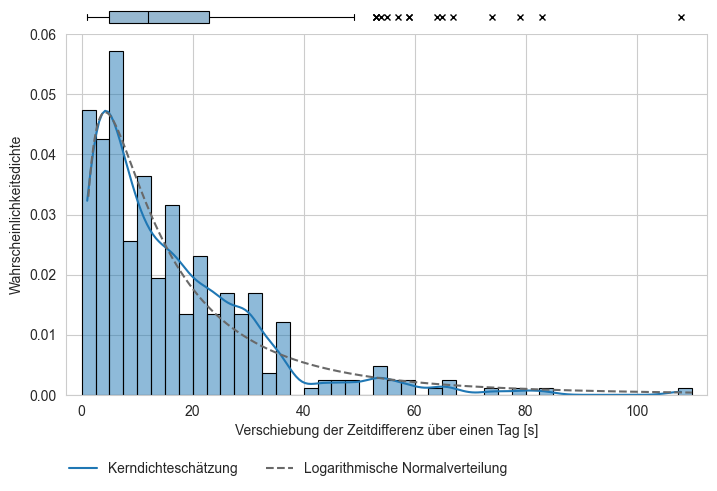

In [7]:
# plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.04, .96)}, figsize=[8.27,5])
#plt.tight_layout(pad=10)
# data
data = dfMissingTime['diff_between_NaN'].dropna()
x = np.arange(0,110.1,0.1)
# box plot without axes
sns.boxplot(x=data, 
            ax=ax_box,
            fill=True,
            flierprops={"marker": "x"},
            fliersize=5,
            color='#8EBAD9',
            linewidth=0.8,
            linecolor='k')
ax_box.axis('off')
# hist plot
bins = sns.histplot(x=data, 
             bins=44, 
             binrange=[min(x),max(x)], 
             kde=True, 
             stat='density', 
             ax=ax_hist, 
             edgecolor='k',
             linewidth=0.8, 
             kde_kws={'bw_adjust':0.5})
# calc lognorm distribution
s, loc, scale = sp.stats.lognorm.fit(data, method='MLE')
lognorm = sp.stats.lognorm.pdf(x[12:], s=s, loc=-1.2, scale=14)
sns.lineplot(x=x[12:],y=lognorm, ax=ax_hist, linestyle='--', color='dimgray')
# set labels
ax_hist.set_xlabel('Verschiebung der Zeitdifferenz über einen Tag [s]')
ax_hist.set_ylabel('Wahrscheinlichkeitsdichte')
# edit margins
ax_hist.margins(x=0.025) 
ax_box.margins(x=0.025) 
plt.subplots_adjust(hspace=0.05)
# remove spines
sns.despine(ax=ax_hist, top=True, right=False)
# legend
legend = ax_hist.legend(loc="upper left", 
                        bbox_to_anchor=(-0.015, -0.15),
                        alignment = 'left', 
                        ncol=2,
                        labels=["Kerndichteschätzung",'Logarithmische Normalverteilung'],
                        frameon=False)
# save figure
f.savefig('diff_between_NaN_hist.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

Über die Zeit betrachtet ist zu sehen, dass bei längerer Laufzeit die Tendenz zu selteneren Nullwerten steigt. Gerade zu Beginn der Messung ist zu beobachten, dass in den ersten vier Tagen keine Sequenz von 40 fehlerfreien Aufrufen am Stück erreicht wurde. Gleichzeitig sind nach dem 1.5-fachen Interquartilsabstand (IQR) Werte über 50 statistisch als Ausreißer nach oben zu werten. Über die weitere Laufzeit treten höhere Werte in zufällig erscheinenden Abständen auf. Um zu verifizieren, ob es diesem Erscheinungsbild ein zufälliger Effekt zugrunde liegt, wäre mindestens eine zweite Messung sinnvoll.

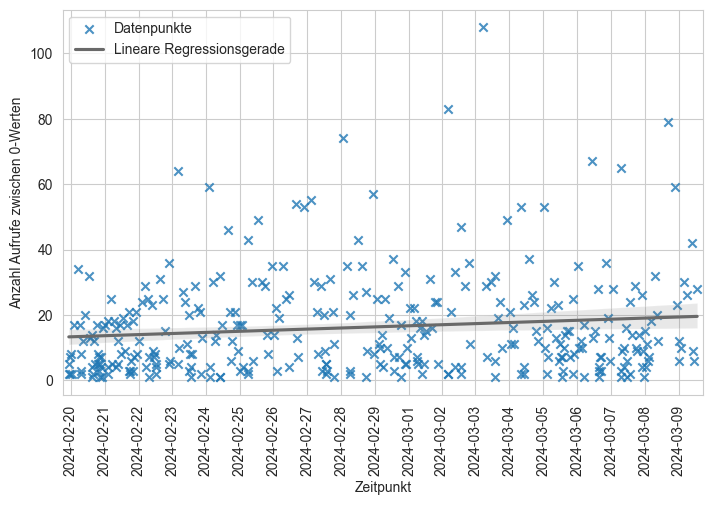

In [8]:
# plot
f = plt.figure(figsize=[8.27,5])
# regression plot
ax = sns.regplot(data=dfMissingTime, 
                 x="counter", 
                 y="diff_between_NaN", 
                 order=1, 
                 marker="x", 
                 line_kws=dict(color='dimgrey',label='Lineare Regressionsgerade'), 
                 color='#1F77B4',
                 label = 'Datenpunkte', 
                 ci=95)
# edit axes
_ = plt.xticks(ticks=df.loc[(df.minute==0) & (df.hour==0) ,'time_before'].index,
               labels=df.loc[(df.minute==0) & (df.hour==0) ,'time_before'].astype(str).str.slice(0,10),
               rotation=90)
_ = plt.xlabel('Zeitpunkt')
_ = plt.ylabel('Anzahl Aufrufe zwischen 0-Werten')
# add legend
ax.legend()
# edit margins
ax.margins(x=0.01) 
# save figure
f.savefig('diff_between_NaN_reg.pdf', bbox_inches='tight')

### Fehlende Daten

Die zweite Art von fehlenden Daten sind Zeitpunkte, zu denen kein Wert aufgenommen wurde. Es sind zwei Zeiträume zu beobachten:
* 23.02.2024 15:20 Uhr bis 15:50 Uhr 
* 01.03.2024 17:05 Uhr bis 18:10 Uhr 

Zu diesen Zeiten war aufgrund von elektrotechnischen Installationen die Sicherung des Stromkreises ausgeschaltet, von welchem auch der Raspberry Pi versorgt wurde.

In [9]:
# create dates
dates = pd.DataFrame(pd.date_range('2024-02-19 21:20', periods=18*24*12+16*12+2, freq='5min'), columns=['datetime'])
# get hour and minute of the day
dates['hour'] = dates['datetime'].dt.hour
dates['minute'] = dates['datetime'].dt.minute
# enumerate days
dates['day'] = dates['datetime'].dt.day.diff().fillna(0)
dates.loc[dates['day'] != 0, 'day'] = 1
dates['day'] = dates['day'].cumsum().astype(int)
# merge
df = dates.merge(df, on=['day','hour','minute'], how='outer')
df = df.sort_values(['day','hour','minute']).reset_index()
# print missing values
df.loc[df.time_before.isna(), 'datetime']

1080   2024-02-23 15:20:00
1081   2024-02-23 15:25:00
1082   2024-02-23 15:30:00
1083   2024-02-23 15:35:00
1084   2024-02-23 15:40:00
1085   2024-02-23 15:45:00
1086   2024-02-23 15:50:00
3117   2024-03-01 17:05:00
3118   2024-03-01 17:10:00
3119   2024-03-01 17:15:00
3120   2024-03-01 17:20:00
3121   2024-03-01 17:25:00
3122   2024-03-01 17:30:00
3123   2024-03-01 17:35:00
3124   2024-03-01 17:40:00
3125   2024-03-01 17:45:00
3126   2024-03-01 17:50:00
3127   2024-03-01 17:55:00
3128   2024-03-01 18:00:00
3129   2024-03-01 18:05:00
3130   2024-03-01 18:10:00
Name: datetime, dtype: datetime64[ns]

Nach dem zweiten Ausfallzeitraum wurde die erste Abfrage erst um 18:14 Uhr gestartet. Zu dieser Zeit läuft kein CronJob und daher ist zu vermuten, dass nach dem Neustart des Raspberry Pis die Durchführung des Tasks von 18:10 Uhr von dem Betiebssystzem verzögert aufgenommen wurde. Dieser Wert ist wegen fehlendem (annähernd) äquidistantem Abstand bezogen auf die anderen nicht verwertbar und wird aus dem DataFrame gelöscht.

In [10]:
df[df.minute%5 != 0]

,index,datetime,hour,minute,day,time_before,time_after,time_ruuvi,diff_before_ruuvi,diff_after_ruuvi
3131,3131,NaT,18,14,11,2024-03-01 18:14:43.180263042+01:00,2024-03-01 18:14:46.448829889+01:00,2024-03-01 18:15:13+01:00,-29.820,-26.551


In [11]:
df = df.drop(index=df[df.minute%5 != 0].index) 

### Verschiebung der Zeitdifferenz zwischen den Tagen

Die Erwartung war, dass durch das tägliche Setzen der Uhrzeit zu der gleichen Tageszeit in etwa die gleiche Zeitdifferenz zu erwarten wäre. Der Datensatz wurde so pivotiert, dass die Tage als Index der Zeilen und die Uhrzeiten die Spalten beschreiben. So lässt sich spaltenweise ablesen, dass die Zeitdifferenz jeden Tag 2 bis 3 Sekunden steigt. Außerdem ist eindeutig zu erkennen, dass der Zeitgeber des RuuviTags schneller läuft, als die des Zeitgebers, da der Wert im negativen wächst.

In [12]:
# pivot column with days as index and time as columns
df_timediff = df.pivot(index='day', columns=['hour','minute'], values='diff_after_ruuvi')
df_timediff

hour        21                                                          \
minute      20      25      30      35      40      45      50      55   
day                                                                      
0        3.276   4.064   3.897   3.750   3.534   4.177   3.506   3.988   
1        0.661     NaN   1.112   1.216   1.044     NaN     NaN   1.003   
2       -1.969  -1.380  -2.068  -1.654  -1.672  -1.505  -1.732  -1.757   
3       -4.630     NaN  -4.832  -4.703  -4.673  -4.374     NaN  -4.417   
4       -6.634  -7.168  -7.144     NaN  -6.800  -7.296  -7.182  -6.805   
5       -9.459  -9.932 -10.202  -9.749  -9.989  -8.986  -9.498  -9.827   
6      -12.086 -12.241 -12.094 -12.279 -12.248 -12.067 -12.481 -12.288   
7      -15.017 -15.730 -15.503 -15.353 -15.631 -15.391 -15.631     NaN   
8      -18.385 -17.781 -18.026 -18.285 -18.454 -17.869 -17.825 -18.260   
9      -20.537 -20.224 -20.597 -21.034 -20.869 -21.182 -21.025 -20.428   
10     -23.273 -23.425 -23.783 -23.403     NaN -23.666 -23.929 -23.403   
11     -25.709 -26.002     NaN -26.028 -26.193 -25.945 -26.603 -26.444   
12     -28.893 -29.311 -28.406 -29.107 -28.684 -28.998 -29.146 -29.193   
13     -31.806 -31.139 -31.748 -31.777 -32.031 -31.757 -31.679 -31.208   
14     -34.007 -34.118 -34.410 -34.731 -34.479 -34.005 -34.016 -34.343   
15     -36.648 -37.107 -37.495     NaN -37.492 -36.953 -37.027 -37.017   
16     -39.914 -40.052 -39.438     NaN -40.240 -39.608 -39.734 -39.970   
17     -42.788 -42.770 -42.653 -42.683 -42.587     NaN -42.168 -43.016   
18     -45.380 -45.304 -45.689 -45.380 -45.574 -44.828 -45.108 -45.359   
19         NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

hour        22          ...      20                                          \
minute      0       5   ...      30      35      40      45      50      55   
day                     ...                                                   
0        3.995   3.641  ...     NaN     NaN     NaN     NaN     NaN     NaN   
1        1.379   0.541  ...   0.907   1.028   0.854     NaN     NaN   0.895   
2       -2.004  -1.723  ...  -1.646  -1.056  -1.928     NaN  -1.535  -1.392   
3       -4.114  -4.010  ...  -4.667  -4.514  -4.635  -4.684  -4.397  -4.437   
4       -7.147  -7.532  ...     NaN  -7.062  -6.518  -7.274  -6.666  -7.268   
5       -9.679     NaN  ...  -9.440  -9.481     NaN -10.042  -9.265  -9.975   
6      -12.359 -12.210  ... -12.399 -12.919 -12.691 -12.782 -11.996 -12.589   
7      -14.922 -15.211  ... -15.487 -15.237 -14.693 -15.146 -15.394 -15.677   
8      -17.981 -17.695  ... -17.526 -18.239 -17.465 -18.305 -18.061 -18.257   
9      -20.652 -21.029  ... -20.306 -20.962 -20.353 -20.151 -20.133 -20.970   
10     -23.319 -23.247  ... -22.997 -23.597 -23.037 -23.676     NaN -23.624   
11     -26.268 -25.931  ... -26.011 -26.067 -25.744 -25.812 -25.767 -26.362   
12     -29.092 -28.491  ... -28.448 -29.006 -28.567 -28.329 -28.502 -28.477   
13     -31.372 -31.906  ... -31.238 -31.990 -31.647 -31.339 -31.183 -31.613   
14     -33.919 -34.789  ... -34.056 -34.063 -34.437 -34.642 -34.270 -33.882   
15     -36.759 -36.741  ... -36.712 -37.392 -36.921     NaN -37.316     NaN   
16     -39.977 -40.280  ... -39.456 -39.764 -39.520 -39.562 -39.426 -39.443   
17     -42.782     NaN  ... -42.064 -41.916 -42.821 -42.085 -42.234 -41.984   
18     -44.950 -45.759  ... -44.752 -45.229 -44.727 -45.124     NaN -44.645   
19         NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   

hour        21                          
minute      0       5       10      15  
day                                     
0          NaN     NaN     NaN     NaN  
1        0.644   0.884   1.285   0.802  
2       -1.365  -2.059  -2.087  -1.770  
3       -4.463  -4.244  -4.112  -4.468  
4       -7.378  -6.996  -7.321  -7.364  
5       -9.874  -9.566  -9.922 -10.262  
6      -12.393 -12.982 -12.999 -12.801  
7      -15.463 -15.444 -14.853 -15.464  
8      -17.534 -18.004 -17.7

Für die Auswertung der Verschiebung der Zeitdifferenzen wird Spaltenweise die Differenz gebildet und die Pivotierung wieder rückgängig gemacht. So entsteht die Verschiebung der Zeitdifferenz zur gleichen Zeit am Vortag. Ein negativer Wert bedeutet, dass die Zeit des RuuviTags um diesen Wert in Sekunden der gemessenen Python-Zeit weiter voreilt, als noch am Vortag. Außerdem werden statistische Kenndaten ausgegeben. Es ist zu erkennen, dass die Zeit täglich im Mittel -2.7 s verschiebt. Der Median und der Mittelwert sind nahezu identisch. 

In [13]:
# calc day diff and reverse pivot 
df_daydiff = df_timediff.diff().melt(value_name='day_diff_of_time_diff', ignore_index=False).reset_index()
# show stats
df_daydiff['day_diff_of_time_diff'].describe()

count   4455.000
mean      -2.723
std        0.412
min       -4.184
25%       -3.017
50%       -2.728
75%       -2.432
max       -1.251
Name: day_diff_of_time_diff, dtype: float64

Das Balkendiagramm zeigt erneut die Wahrscheinlichkeitsdichte mit zugehöriger Kerndichteschätzung. Die resultierende Verteilung entspricht einer Dreiecksverteilung, welche ebenfalls eingezeichnet ist. Für die Dreiecksverteilung werden die Daten mithilfe der IQR-Methode von Ausreißern beseitigt, da für die korrekte Berechnunng das korrekte Minimum, Maximum sowie der Mittelwert wesentlich sind. Die Berechnung folgt mit der scipy.stats Methode triang [[12]](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html) mit den dort angegebenen, umgestellten Formeln:
$$loc = min(X)$$
$$scale = max(X)-min(X)$$
$$c = \frac{\overline{X}-loc}{scale}$$
Wobei $loc$ den Beginn der Verteilung abbildet und $scale$ die Spannweite des Dreiecks. $c$ beschreibt die Steigung des ersten Dreiecksschenkels, die Steigung des zweiten Schenkels kann über $c-1$ berechnet werden. Die Steigung liegt in diesem Fall bei 0.491 und bildet damit annähernd ein gleichschenkliges Dreieck.

c: 0.49133905150196855


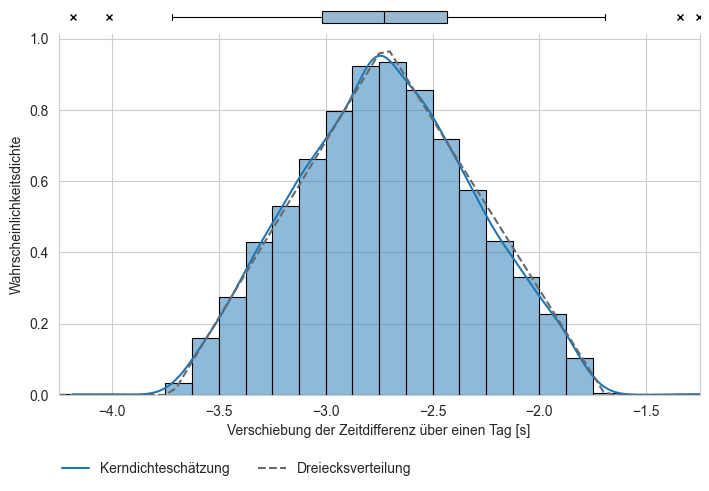

In [14]:
# plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.04, .96)}, figsize=[8.27,5])
# data
data = df_daydiff['day_diff_of_time_diff']
x = np.arange(-4.25,-1.2,0.05)
# box plot without axes
sns.boxplot(x=data, 
            ax=ax_box,
            fill=True,
            flierprops={"marker": "x"},
            fliersize=5,
            color='#8EBAD9',
            linewidth=0.8,
            linecolor='k')
ax_box.axis('off')
# hist plot
sns.histplot(x=data, 
             bins=24, 
             binrange=[min(x),max(x)], 
             kde=True, 
             stat='density', 
             ax=ax_hist, 
             edgecolor='k',
             linewidth=0.8)
# clear outliers with iqr
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3-q1
data_iqr = data[(data>q1-1.5*iqr) & (data<q3+1.5*iqr)]
# calc distribution
loc = np.min(data_iqr)
scale = np.max(data_iqr)-np.min(data_iqr)
c = (np.mean(data_iqr)-loc)/scale
triang = sp.stats.triang.pdf(x, c=c ,loc=loc, scale=scale)
sns.lineplot(x=x,y=triang, ax=ax_hist, linestyle='--', color='dimgray')
print('c:', c)
# set labels
ax_hist.set_xlabel('Verschiebung der Zeitdifferenz über einen Tag [s]')
ax_hist.set_ylabel('Wahrscheinlichkeitsdichte')
# edit margins
ax_hist.margins(x=0) 
ax_box.margins(x=0) 
plt.subplots_adjust(hspace=0.05)
# remove spines
sns.despine(ax=ax_hist, top=True, right=False)
# legend
legend = ax_hist.legend(loc="upper left", 
                        bbox_to_anchor=(-0.015, -0.15),
                        alignment = 'left', 
                        ncol=2,
                        labels=["Kerndichteschätzung","Dreiecksverteilung"],
                        frameon=False)
# save figure
f.savefig('day_diff_of_time_diff_hist.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

### Abweichung der Zeitdifferenzen

Die Abweichung der Zeitdifferenzen zwischen zwei RuuviTag-Abfragen liegt sowohl der Mittelwert als auch Median bei gerundet -0.01 s, also knapp bei null mit einer leichten Tendenz für einen vorlaufenden Zeitgeber. Auch wenn dieser Wert verschwindend gering wirkt, sind bei 12 Abfragen die Stunde und 24 Stunden -2.698 s Zeitverschiebung täglich zu erwarten, was in etwa der vorher statistisch ermittelten Tagesdifferenz von -2.723 s entspricht.  

Für die Ermittlung der Statistik wurden die Zeitpunkte, nach denen die Zeit des RuuviTags gesetzt wurde, gesondert betrachtet. Für diesen Datensatz von 17 gültigen Werten ist zu beobachten, dass vermehrt positive Werte auftreten. Das könnte daher kommen, dass der Zeitgeber des Tags zurückgesetzt wurde. Durch die kleine Stichprobe ist jedoch nicht auszuschließen, dass es sich hierbei um Zufall handelt. Das Zurücksetzen der Uhr ergibt im Schnitt nur 0.14 s statt der beschriebenen täglichen Differenz von -2.7 s, weshalb die Zeit trotz dem Zurücksetzen über die Tage driftet. Außerdem lässt sich hieraus schließen, dass das Zurücksetzen nicht auf die erwartete Weise funktioniert. Es ist unsicher, ob es sich hierbei um ein Phänomen von BLE handelt, eine andere Fehlfunktion der Kommunikation (z. B. durch bleak) oder noch ein anderer, unbekannter Fehler dieses Verhalten verursacht.

In [15]:
# calc diffs of timediffs
df['diff_of_time_diff'] = df['diff_after_ruuvi'].diff()
# print theoretical daily diff
print('Erwartete tägliche Zeitverschiebung:',df['diff_of_time_diff'].mean()*12*24)
print('Nicht gerundeter Mittelwert:',df['diff_of_time_diff'].mean())
print('Nicht gerundeter Median:',df['diff_of_time_diff'].median(),'\n')
# values after set time are NaN
set_diff = df.loc[(df.hour==21) & (df.minute==20),'diff_of_time_diff'] 
df.loc[(df.hour==21) & (df.minute==20),'diff_of_time_diff'] = np.nan
# calc stats
print('Datensatz ohne Werte nach dem Setzen:\n',df['diff_of_time_diff'].describe(),'\n')
print('Nur Werte nach dem Setzen:\n',set_diff.describe(),'\n')

Erwartete tägliche Zeitverschiebung: -2.6982119937501627
Nicht gerundeter Mittelwert: -0.009368791644965842
Nicht gerundeter Median: -0.011069536209106667 

Datensatz ohne Werte nach dem Setzen:
 count   4695.000
mean      -0.010
std        0.414
min       -1.966
25%       -0.312
50%       -0.011
75%        0.288
max        1.335
Name: diff_of_time_diff, dtype: float64 

Nur Werte nach dem Setzen:
 count   17.000
mean     0.137
std      0.376
min     -0.362
25%     -0.162
50%      0.133
75%      0.390
max      0.803
Name: diff_of_time_diff, dtype: float64 



Die Verteilung dieser Werte gleicht ebenfalls einer Dreiecksverteilung mit dem Mittelpunkt um -0.01 s. Im Boxplot ist zu sehen, dass oberhalb drei Ausreißer und unterhalb ein Ausreißer zu finden sind, weshalb die Daten aus den zuvor geschilderten Gründen mithilfe der IQR-Methode von Ausreißern bereinigt werden. Die Steigung $c$ liegt in diesem Fall auf die vierte Nachkommastelle gerundet bei 0.5, womit das Dreieck nahezu gleichschenklig ist. Das zeigt, dass die Daten symmetrisch um den Mittelpunkt liegen.

c: 0.5002110788125524


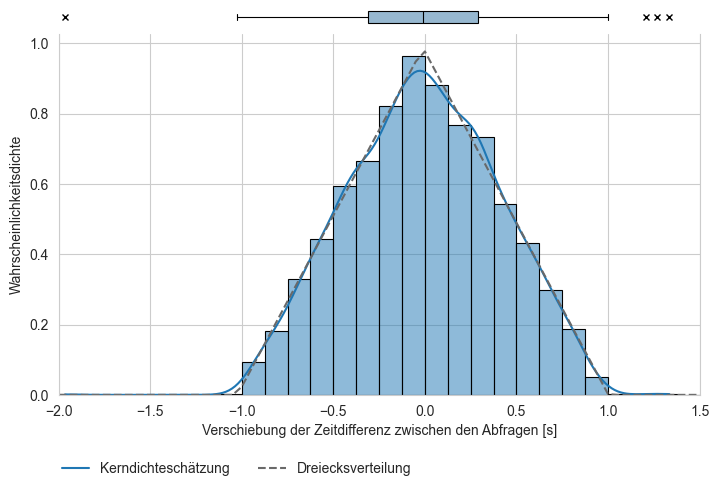

In [16]:
# plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.04, .96)}, figsize=[8.27,5])
# data
data = df['diff_of_time_diff']
x = np.arange(-2,1.55,0.05)
# box plot without axes
sns.boxplot(x=data, 
            ax=ax_box,
            fill=True,
            flierprops={"marker": "x"},
            fliersize=5,
            color='#8EBAD9',
            linewidth=0.8,
            linecolor='k')
ax_box.axis('off')
# hist plot
sns.histplot(x=data, 
             bins=28, 
             binrange=[min(x),max(x)], 
             kde=True, 
             stat='density', 
             ax=ax_hist, 
             edgecolor='k',
             linewidth=0.8)
# clear outliers with iqr
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3-q1
data_iqr = data[(data>q1-1.5*iqr) & (data<q3+1.5*iqr)]
# calc distribution
loc = np.min(data_iqr)
scale = np.max(data_iqr)-np.min(data_iqr)
c = (np.mean(data_iqr)-loc)/scale
triang = sp.stats.triang.pdf(x, c=c ,loc=loc, scale=scale)
sns.lineplot(x=x,y=triang, ax=ax_hist, linestyle='--', color='dimgray')
print('c:', c)
# set labels
ax_hist.set_xlabel('Verschiebung der Zeitdifferenz zwischen den Abfragen [s]')
ax_hist.set_ylabel('Wahrscheinlichkeitsdichte')
# edit margins
ax_hist.margins(x=0) 
ax_box.margins(x=0) 
plt.subplots_adjust(hspace=0.05)
# remove spines
sns.despine(ax=ax_hist, top=True, right=False)
# legend
legend = ax_hist.legend(loc="upper left", 
                        bbox_to_anchor=(-0.015, -0.15), #(-0.08,1.12)
                        alignment = 'left', 
                        ncol=2,
                        labels=["Kerndichteschätzung","Dreiecksverteilung"],
                        frameon=False)
# save figure
f.savefig('diff_of_time_diff_hist.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

Auch die Betrachtung über die Zeit ist relevant, weil denkbar wäre, dass die Abweichung sich über die Zeit vergrößert. Der Scatterplot mit Regressionsgerade zeigen jedoch, dass die Abweichung sich als Rauschen über den gesamten Messzeitraum hinweg identisch verhält. Eine Ausnahme bilden die vier Ausreißer, die auf den gesamten Datensatz gesehen weniger als 0.0009 % der auswertbaren Datenpunkte ausmachen. Die Quote von 3:1 deutet darauf hin, dass Ausreißer nach oben etwas wahrscheinlicher sind. Für eine genauere Aussage wären weitere Messungen notwendig, da es sich bei dieser Beobachtung auch um einen Zufall handeln könnte.

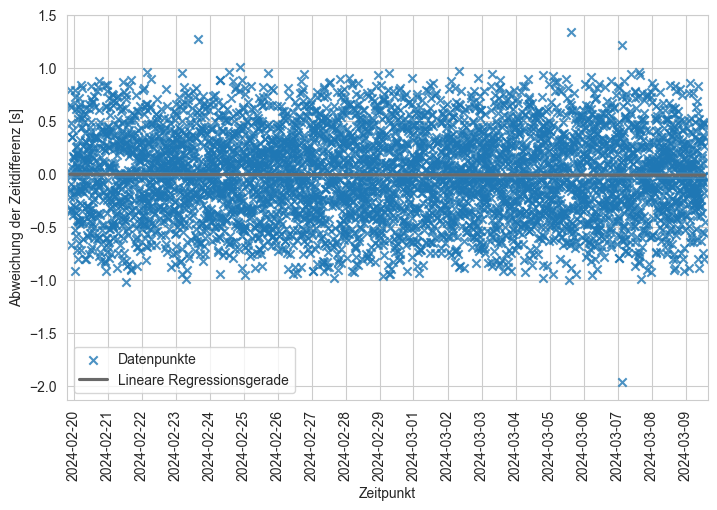

In [17]:
# plot
f = plt.figure(figsize=[8.27,5])
# regression plot
ax = sns.regplot(data=df, 
                 x="index", 
                 y="diff_of_time_diff", 
                 order=1, 
                 marker="x", 
                 line_kws=dict(color='dimgrey',label='Lineare Regressionsgerade'), 
                 color='#1F77B4',
                 label = 'Datenpunkte', 
                 ci=95)
# edit axes
_ = plt.xticks(ticks=df.loc[(df.minute==0) & (df.hour==0) ,'time_before'].index,
               labels=df.loc[(df.minute==0) & (df.hour==0) ,'time_before'].astype(str).str.slice(0,10),
               rotation=90)
_ = plt.xlabel('Zeitpunkt')
_ = plt.ylabel('Abweichung der Zeitdifferenz [s]')
# add legend
ax.legend()
# edit margins
ax.margins(x=0.005) 
# save figure
f.savefig('diff_of_time_diff_reg.pdf', bbox_inches='tight')

### Bereinigte Differenz

Um die Kernfrage des Zeitdrifts über einen Tag zu beantworten, wird eine angepasste Zeitdifferenz berechnet. Das heißt, dass die Zeitdifferenz nach dem Setzen der Zeit von den Differenzen des gesamten folgenden Tags abgezogen wird. Anders als bei den anderen Analysen, sind übliche statistische Kennzahlen auf den ganzen Datensatz angewandt nicht aussagekräftig, da eine systematische Verschiebung der Zeitdifferenz über den Tag erwartet wird.  

Aus diesem Grund werden die Tage in 48 halbe Stunden aufgeteilt, angefangen nach dem Setzen der Zeit um 21:20 Uhr. Diese werden von 0 bis 47 zyklisch durchnummeriert. Eine halbe Stunde ist der geschätzte Wert, bei dem eine Gruppierung der Differenzen als sinnvoll zu erachten ist.

In [18]:
# calc adjusted timediffs
df['adjusted_time_diff'] = df.apply(lambda x: x['diff_after_ruuvi'] if (x.hour==21) & (x.minute==20) else np.nan, axis=1)
df['adjusted_time_diff'] = df['adjusted_time_diff'].ffill()
df['adjusted_time_diff'] = df['diff_after_ruuvi'] - df['adjusted_time_diff']
# create time without date
df['time'] = df.apply(lambda x: datetime.time(x.hour,x.minute), axis=1 )
# calc half hours
df['half_hour'] = df.apply(lambda x: 1 if (x.minute==20) | (x.minute==50) else 0, axis=1)
df['half_hour'] = (df['half_hour'].cumsum()-1)%48

In der Darstellung sind die Mittelwerte der aggregierten halben Stunden mit 95 %-igem Konfidenzintervall zu sehen. Wichtig ist, dass die eingefügte Regressionsgerade nicht auf die Mittelwerte, sondern auf die ursprünglichen Datenpunkte bezogen ist. Hier ist deutlich zu erkennen, dass die ursprüngliche Annahme der Vergrößerung der Differenz zwischen den Uhren zutrifft. Annähernd kontinuierlich eilt der interne Zeitgeber des RuuviTags der Zeit des Gateways wie bereits ermittelt täglich um ungefähr 2.7 s voraus. Pro Stude sind das in etwa 113 ms Zeitverschiebung.

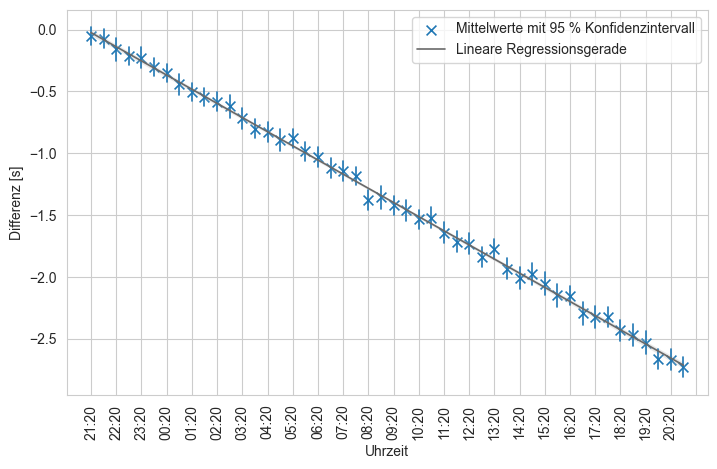

In [19]:
# figure
f = plt.figure(figsize=[8.27,5])
# linewidth
lw = 1.2
# regression plot with error bars
ax = sns.regplot(data=df, 
                 x="half_hour", 
                 y="adjusted_time_diff", 
                 order=1, 
                 marker="x", 
                 line_kws=dict(color='dimgrey', label='Lineare Regressionsgerade', linewidth=lw), 
                 scatter_kws=dict(linewidth=lw),
                 color='#1F77B4',
                 label = 'Mittelwerte mit 95 % Konfidenzintervall',
                 x_bins=np.arange(0, 48, 1),
                 x_ci=95, 
                 ci=95)
for line in ax.lines: line.set_linewidth(lw) 
# edit axes
_ = plt.xticks(ticks=np.arange(0,50,2),
               labels=pd.concat([df.loc[(df.minute==20)  ,'time'].astype(str).str.slice(0,5)[:24],pd.Series([''])]),
               rotation=90)
_ = plt.xlabel('Uhrzeit')
_ = plt.ylabel('Differenz [s]')
# add legend
ax.legend()
# edit margins
ax.margins(x=0.041) 
# save figure
f.savefig('adjusted_time_diff_reg.pdf', bbox_inches='tight')

## Synchronisation

Der Vorschlag für die Häufigkeit der Synchronisation erfolgt unter der Annahme, dass die Abweichung auch für andere RuuviTags in etwa -2.7 s bzw. -9.37 ms pro 5 min beträgt. Außerdem müsste sichergestellt werden, dass die Synchronisation ordnungsgemäß funktioniert, was wie beschrieben aus den bisherigen Ergebnissen nicht abzuleiten ist.  

Werden die Aufnahmen für das Labeling der Beschleunigungsdaten mit einer Bildwiederholungsrate von 30 fps aufgenommen, wird alle 33.3 ms ein Frame generiert. Bei der genannten mittleren Abweichung würde sich alle 8.9 min die RuuviTag-Zeit um ein halbes Frame verschieben. Spätestens nach dieser Zeit sollte daher eine Synchronisation durchgeführt werden, damit über die Hälfte der Beschleunigungsdaten auch diesem Frame zuzuordnen sind. Bei einer höheren Bildwiederholungsrate verkürzt sich folglich der Abstand zwischen zwei Synchronisationsvorgängen ebenso wie bei einer gewünschten höheren Genauigkeit.  

Für das Labeling der Daten kann jedoch auf andere Weise synchronisiert werden. Beispielsweise können drei gezielte *Hiebe* auf den RuuviTag während der Videoaufnahmen dafür sorgen, dass charakteristische Spitzen in den Beschleunigungsdaten erzeugt werden. Die können anschließend mit den Bilddaten für das Labeling korrekt übereinander gelegt werden.  

Weitere Anwendungen mit dem RuuviTag sind nicht weiter spezifiziert und müssen im Einzelfall erneut betrachtet werden. Im Gebrauch als Fitnesstracker kann es beispielsweise ausreichen, die Zeit stündlich oder täglich zu synchronisieren sofern die ausgeführten Bewegungen korrekt erkannt werden.

## Fazit und weitere Schritte

Bei der Zeitabfrage des RuuviTags wurde annähernd logarithmisch normalverteilt fehlende Werte (0-Werte) festgestellt. Die Gründe für das Fehlen dieser Werte wurden nicht näher untersucht.  

Außerdem wurde ein täglicher Timedrift von -2.7 s bzw. -9.37 ms pro 5 min ermittelt. Über eine Bereinigung der einzelnen Tageswerte wurde festgestellt, dass dieser Drift sich linear über den Tag fortsetzt. Die Abweichungen zwischen einzelnen Messwerten sind als zufälliges Rauschen dreiecksverteilt.  

Weiterhin wurde beobachtet, dass die Zeit unabhängig vom Setzen der Zeit weiter driftet. Der Hintergrund dessen konnte nicht ermittelt werden und es gibt verschiedene Möglichkeiten für die Ursache. Eine davon könnte sein, dass das Setzen der Zeit nicht in der wie es zu erwarten funktioniert. Da beim Abfragen der Zeit ebenfalls Fehler (0-Werte) auftreten, ist auch ein Fehler beim Setzen denkbar. Dieses Verhalten sollte weiter untersucht werden, es bietet sich im ersten Schritt das Update der bleak-Version mit weiteren anschließenden Tests an.  

Die Synchronisation des Labelings kann auch über gezielte Zeichen wie *Hiebe* auf den RuuviTag erfolgen, da sich die Synchronisation über das Setzen des Zeitgebers zum aktuellen Zeitpunkt nicht als zuverlässig erwiesen hat. Ein Synchronisationsvorgang sollte bei 30 fps spätestens alle 8 bis 9 min erfolgen, damit mindestens die Häfte der Bewegungsdaten dem entsprechenden Frame auch zuzuordnen sind.  

Zu Beachten ist, dass für diese Auswertung ein einziger RuuviTag herangezogen wurde. Es ist im Bereich des Möglichen, dass die ermittelten Werte speziefisch auf diesen einen Tag zutreffen. Außerdem bleibt durch die Ungenauigkeit der Methode über BLE eine Restunsicherheit. Weitere Validierungsmessungen unterschiedlicher Tags möglichst aus unterschiedlichen Lieferchargen könnten das Ergebnis weiter eingrenzen. Mögliche Temperatureffekte wurden ebenfalls nicht mit einbezogen und sind insbesondere wichtig, sobald der Tag außerhalb von Laborbedingungen einen Einsatz findet.

